# Doppler smearing

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import scipy

import setigen as stg

In [6]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

When a cosine signal is Doppler drifted, the frequency response smears out the signal power across frequency bins, as a function of the drift rate. For low drift rates, there isn't a significant change, but when a signal spans multiple frequency bins in a single time bin, observed signal power decreases accordingly. The data resolution can therefore be a strong factor in how much Doppler smearing occurs. 

To see this effect for "real", you can use `setigen.voltage` to simulate a drifting cosine signal at high drift rates. However, generating raw voltage data, even using a GPU, can be computationally expensive. In this notebook, we explore methods of simulating this effect directly in time-frequency space.

## Modeling the linear chirp frequency response in time-frequency space

### Manually specifying widths and intensities

The simplest way to approximate these effects is to manually include them. 

We define the "unit drift rate" for a given data resolution to be the drift rate given by `df / dt`. Setigen's Frame object provides the property `frame.unit_drift_rate = frame.df / frame.dt` for convenience. Then, a signal traveling at this drift rate will appear to shift by one pixel in frequency per one pixel shift in time, i.e. a pixel by pixel slope of 1. 

So for signals with a drift rate higher than the unit drift rate by what we'll call the "drift factor", we can approximate the width and intensity attenuation of the signal. Namely, if we use a "box" spectral profile, we extend the signal width to be `drift_factor` pixels and diminish the signal level by `drift_factor`. This makes sense intuitively; if our signal crosses `n` frequency bins over one time step, the signal power should be spread equally in those `n` bins. 

Note that this approximation is better the larger `drift_factor` is, and only even applicable when `drift_factor >= 1`. 

Doing this with a simple signal drifting 4 times the unit drift rate:

In [ ]:
drift_factor = 1

#fr = "Blank for Seti.rawspec.0000.fil"
print(f'The unit drift rate is {fr.unit_drift_rate:.2f} Hz/s.')
drift_rate = drift_factor * fr.unit_drift_rate
print(f'The signal drift rate is {drift_rate:.2f} Hz/s.')
fr.add_constant_signal(f_start=fr.get_frequency(16),
                       drift_rate=drift_rate,
                       level=1 / drift_factor,
                       width=fr.df * drift_factor,
                       f_profile_type='box')
fr.plot()
plt.show()

Adding noise, and comparing the drifting signal with a non-drifting signal of identical starting intensity:

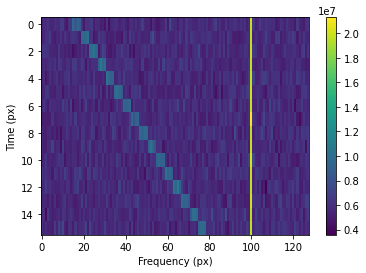

In [8]:
drift_factor = 4
snr = 100

fr = stg.Frame(shape=(16, 128))
drift_rate = drift_factor * fr.unit_drift_rate
fr.add_noise_from_obs()
fr.add_constant_signal(f_start=fr.get_frequency(16),
                       drift_rate=drift_rate,
                       level=fr.get_intensity(snr=snr) / drift_factor,
                       width=fr.df * drift_factor,
                       f_profile_type='box')
fr.add_constant_signal(f_start=fr.get_frequency(100),
                       drift_rate=0,
                       level=fr.get_intensity(snr=snr),
                       width=fr.df,
                       f_profile_type='box')
fr.plot()
plt.show()

This kind of process is straightforward when signals are simple, linear, and assumed to be very narrow (pixel-width). Nevertheless, it is certainly unsophisticated (which might be fine for some applications!).

If we assume perfect cosine signals, we can do a bit better: mathematically correct chirp spectrums.

### Analytically described chirp spectrum

It turns out that the frequency response for a drifting signal can only be analytically expressed for a linear chirp. We follow the derivation here: https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp to write a custom `f_profile`:

In [9]:
def analytic_chirp(drift_rate, df, dt):
    """
    Analytic chirp spectrum, based on https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp.
    """
    dF = drift_rate * dt 
    dW = 2 * np.pi * dF
    const = np.pi * df / abs(dW)

    def f_profile(f, f_center):
        dw = 2 * np.pi * (f - f_center)
        X1 = (dw) / np.sqrt(np.pi * abs(dW) / dt)
        X2 = (dW - dw) / np.sqrt(np.pi * abs(dW) / dt)
        
        S1, C1 = scipy.special.fresnel(X1)
        S2, C2 = scipy.special.fresnel(X2)
        
        return const * ((C1 + C2)**2 + (S1 + S2)**2)
    return f_profile

There are some important deviations we made from the derivation to faciliate signal injection. Firstly, we care about sample frequency over angular frequency, so we have to be sure to stay in the correct units. Then, the constant in the expression for power doesn't give us useful values for intensity, so we additionally multiply by `frame.df / frame.dt` to get to the right units. Finally, we translate the frequency variable by `dW / 2` so that `f_start` is truly where our drifting signal starts.

One note about this is that generally in `setigen`, `f_start` in the path refers to the *center* of the signal at the starting time bin. In this case, the edge of the smeared frequency response will actually be at `f_start`, not the center. This frequency can be easily shifted by preference, but doing it this way actually matches the result when simulating a drifting cosine signal in voltage space with `setigen.voltage`. 

Trying this out in a synthetic frame:

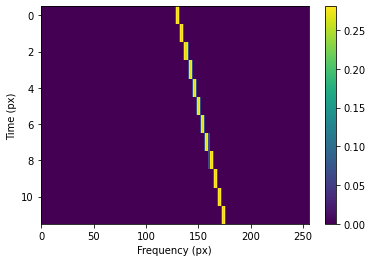

In [10]:
fr = stg.Frame(shape=(12, 256))

drift_rate = 4 * fr.unit_drift_rate
fr.add_signal(stg.constant_path(f_start=fr.get_frequency(128),
                                drift_rate=drift_rate),
              stg.constant_t_profile(level=1),
              analytic_chirp(drift_rate, fr.df, fr.dt),
              stg.constant_bp_profile(level=1))

fr.plot()
plt.show()

Looks good! Let's try a higher drift rate to see the detailed spectrum in adjacent time bins:

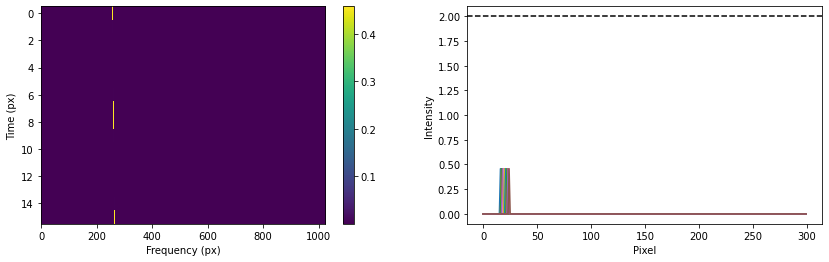

In [11]:
fr = stg.Frame(shape=(16, 1024))

drift_rate = 0.5 * fr.unit_drift_rate

fr.add_signal(stg.constant_path(f_start=fr.get_frequency(256),
                                drift_rate=drift_rate),
              stg.constant_t_profile(level=1),
              analytic_chirp(drift_rate, fr.df, fr.dt),
              
              stg.constant_bp_profile(level=1))

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
fr.plot()

# Zoom in on individual spectra
plt.subplot(1, 2, 2)
for i in range(16):
    plt.plot(fr.data[i][240:540])
# plt.plot(fr.data[1][240:600])
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.axhline(fr.unit_drift_rate / drift_rate, ls='--', c='k')
plt.show()

We readily see the squiggle structure in the spectrum, and sharp drop-offs at the edges. As the signal goes to the next time bin, a similar spectra is repeated, starting at the end of the previous one. 

Also, notice that the average intensity of these spectral responses matches `frame.unit_drift_rate / drift_rate`, as expected!

Although it's nice to see the spectral structure without having to simulate the signal in voltage space, this analytic solution only works for linearly drifting, cosine signals. Intrinsically broader or more complex signals can't really be simulated the same way, even though they would also exhibit Doppler smearing to some degree.

### Doppler smearing by repeated sampling

For complex cases, no single solution handles all signals appropriately. Nevertheless, we can get an approximation when using `frame.add_signal()` by way of the `doppler_smearing` and `smearing_subsamples` parameters. 

If `doppler_smearing=True`, `frame.add_signal()` will take the mean of signal copies evenly spaced between the center frequencies at times `t` and `t+1`. The `smearing_subsamples` parameter controls how many such copies to include in the calculation; the default is 10. To get enough coverage, a good rule of thumb is to have `smearing_subsamples >= drift_factor = drift_rate / frame.unit_drift_rate`.

This way, the spectral profile within a single time bin will be intrinsically broadened by nature of the sampling. For example, if the width of the signal is 1 pixel and the signal is smeared over 4 pixels with `smearing_subsamples=4`, the intensity in each pixel will go down by 4, since we're taking the mean. So, we end up with a result similar to that of our first method, but without having to manually input the attenuation!

As an example:

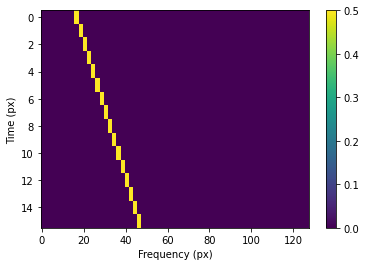

In [12]:
drift_factor = 2

fr = stg.Frame(shape=(16, 128))
drift_rate = drift_factor * fr.unit_drift_rate
fr.add_signal(stg.constant_path(f_start=fr.get_frequency(16),
                                drift_rate=drift_rate),
              stg.constant_t_profile(level=1),
              stg.box_f_profile(width=fr.df),
              doppler_smearing=True,
              smearing_subsamples=drift_factor)
fr.plot()
plt.show()

We can also do the same with `add_constant_signal()`, with the `doppler_smearing` boolean parameter:

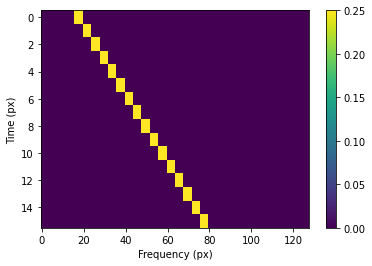

In [13]:
drift_factor = 4

fr = stg.Frame(shape=(16, 128))
drift_rate = drift_factor * fr.unit_drift_rate
fr.add_constant_signal(f_start=fr.get_frequency(16),
                       drift_rate=drift_rate,
                       level=1,
                       width=fr.df,
                       f_profile_type='box',
                       doppler_smearing=True)
fr.plot()
plt.show()

Finally, for a more complex example, let's make a quadratic-path signal:

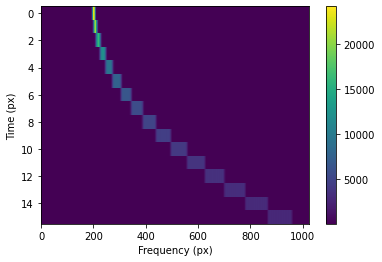

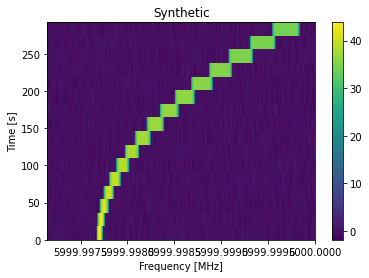

In [14]:
fr = stg.Frame(shape=(16, 1024))
fr.add_noise(1)
fr.add_signal(stg.squared_path(f_start=fr.get_frequency(200),
                               drift_rate=0.05*u.Hz/u.s),
              stg.constant_t_profile(level=fr.get_intensity(snr=1e6)),
              stg.sinc2_f_profile(width=fr.df*10),
              doppler_smearing=True,
              smearing_subsamples=10)
fr.plot()
plt.show()

fr.bl_plot()
plt.show()

Since this method relies on multiple computations of the signal, this process can take a while longer than a one-shot approximation, such as the first method. 

Each method presented above has its pros and cons; different applications may require differing methods.